In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.aqua.components import variational_forms
from qiskit.aqua.components.optimizers import COBYLA, SPSA

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from data_provider import load_titanic_pd
from utils import record_test_result_for_kaggle

In [2]:
df_train, y_train, df_test = load_titanic_pd('train.csv', 'test.csv')

/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = numer_map[df[col][i]]
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = value


     Survived  Pclass Sex Age  SibSp  Parch      Fare Embarked
0           0       3   0  22      1      0    7.2500        0
1           1       1   1  38      1      0   71.2833        1
2           1       3   1  26      0      0    7.9250        0
3           1       1   1  35      1      0   53.1000        0
4           0       3   0  35      0      0    8.0500        0
5           0       3   0  30      0      0    8.4583        2
6           0       1   0  54      0      0   51.8625        0
7           0       3   0   2      3      1   21.0750        0
8           1       3   1  27      0      2   11.1333        0
9           1       2   1  14      1      0   30.0708        1
10          1       3   1   4      1      1   16.7000        0
11          1       1   1  58      0      0   26.5500        0
12          0       3   0  20      0      0    8.0500        0
13          0       3   0  39      1      5   31.2750        0
14          0       3   1  14      0      0    7.8542  

/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = value


In [5]:
for col in df_train.columns:
    print(f"{col}: unique {len(df_train[col].unique())}")

Pclass: unique 3
Sex: unique 2
Age: unique 88
SibSp: unique 7
Parch: unique 7
Fare: unique 248
Embarked: unique 4


In [6]:
# Age processing

df_train['Age'] = df_train.Age // 10
df_test['Age'] = df_test.Age // 10

In [7]:
def fare_map(x):
    if x < 10:
        return 0
    if x < 20:
        return 1
    if x < 30:
        return 2
    else:
        return 3
    
df_train['Fare'] = df_train['Fare'].apply(fare_map)
df_test['Fare'] = df_test['Fare'].apply(fare_map)

In [8]:
df_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,2,1,0,0,0
1,1,1,3,1,0,3,1
2,3,1,2,0,0,0,0
3,1,1,3,1,0,3,0
4,3,0,3,0,0,0,0


In [13]:
from sklearn import preprocessing

df_all = pd.concat([df_train, df_test])
# Encode to number
for col in df_train.columns:
    le = preprocessing.LabelEncoder().fit(df_all[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

In [14]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()


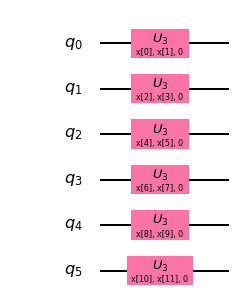

In [15]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

var_form = variational_forms.RYRZ(num_qubit)

qc = QuantumCircuit(num_qubit)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder

feature_map = qc 
feature_map.draw('mpl')

In [17]:
# Make training data

training_input = {
    0: data_train[y_train == 0],
    1: data_train[y_train == 1]
}

In [25]:
# 

seed = 10598

vqc_encode_only_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_only_log.append(loss)

qsvm_encode = VQC(COBYLA(100), feature_map, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  if __name__ == '__main__':
2020-07-09 00:30:00,440:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-09 00:30:00,454:qiskit.aqua.algorithms.v

KeyboardInterrupt: 

In [ ]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(prediction, 'submission.csv')

In [36]:
prediction = np.zeros(len(df_test))
record_test_result_for_kaggle(prediction, 'stupid_submission.csv')

In [ ]:
qsvm_encode.save_model('models/Titanic_VQC')

In [26]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC.npz')

In [28]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-09 00:33:37,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


NameError: name 'f1' is not defined

In [33]:
np.mean(prediction == y_train), f1_score(prediction, y_train)

(0.675645342312009, 0.5743740795287187)

# Continuous+mix encoding (VQC + QRAC)

In [2]:
df_train, y_train, df_test = load_titanic_pd('train.csv', 'test.csv')

/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = numer_map[df[col][i]]
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col][i] = value
/Users/barnrang/Desktop/work/github/qc_group_project/data_provider.py:101: SettingWithCopyWarning: 
A value is trying to be set

     Survived  Pclass Sex Age  SibSp  Parch  Fare Embarked
0           0       3   0   2      1      0     0        0
1           1       1   1   3      1      0     3        1
2           1       3   1   2      0      0     0        0
3           1       1   1   3      1      0     3        0
4           0       3   0   3      0      0     0        0
5           0       3   0   3      0      0     0        2
6           0       1   0   5      0      0     3        0
7           0       3   0   0      3      1     2        0
8           1       3   1   2      0      2     1        0
9           1       2   1   1      1      0     3        1
10          1       3   1   0      1      1     1        0
11          1       1   1   5      0      0     2        0
12          0       3   0   2      0      0     0        0
13          0       3   0   3      1      5     3        0
14          0       3   1   1      0      0     0        0
15          1       2   1   5      0      0     1       

In [3]:
df_train['Fare'] = np.log(df_train['Fare'] + 1)
df_test['Fare'] = np.log(df_test['Fare'].astype(np.float32) + 1)

In [23]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,0.05,0,0,0.000000,0
1,3,1,0.0666667,1,0,0.000000,1
2,2,0,0.1,0,0,0.000000,0
3,3,0,0.0333333,0,0,0.000000,1
4,3,1,0.0333333,1,1,0.693147,1


In [22]:
df_test['Fare'].head(10)

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    0.693147
5    0.000000
6    0.000000
7    1.098612
8    0.000000
9    1.098612
Name: Fare, dtype: float32

In [6]:
df_train['Age'] = df_train['Age'] / 60
df_test['Age'] = df_test['Age'] / 60

In [7]:
cat_col = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
num_col = ['Age', 'Fare']

In [8]:
df_train_cat = df_train[cat_col]
df_test_cat = df_test[cat_col]

df_train_num = df_train[num_col]
df_test_num = df_test[num_col]

In [9]:
# b1b2b3 --> (theta, varphi)
def convert_to_angle(b_st):
    if b_st[0] == '1':
        theta = np.arccos(1/np.sqrt(3))
    else:
        theta = np.arccos(-1/np.sqrt(3))

    if b_st[1] == '1' and b_st[2] == '1':
        varphi = np.pi / 4

    if b_st[1] == '1' and b_st[2] == '0':
        varphi = 3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '0':
        varphi = -3 * np.pi / 4

    if b_st[1] == '0' and b_st[2] == '1':
        varphi = -np.pi / 4
            
    return [theta, varphi]

data_train = []
data_test = []

bit_each_col = []

df_all = pd.concat([df_train_cat, df_test_cat])

# Check number of different category in df_all
for col in df_all.columns:
    bit_each_col.append(int(np.ceil(np.log2(len(df_all[col].unique())))))
    
# Count required bit
num_bit = sum(bit_each_col)
num_qubit = int(np.ceil(num_bit / 3))

pad = 0
if num_bit % 3 != 0:
    pad = 3 - (num_bit % 3)

    
# Encode train
for row in df_train_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_train.append(var_list)
    
# Encode Test
for row in df_test_cat.values:
    bstring = ''
    
    for v, num_bit in zip(row, bit_each_col):
        bstring += f"{v:010b}"[-num_bit:]
        
    all_b_st = bstring + pad * '0'
    
    var_list = []
    for i in range(num_qubit):
        b_st = all_b_st[i * 3: (i+1) * 3]
        var_list += convert_to_angle(b_st)
    
    data_test.append(var_list)

# data = np.concatenate(data, axis=1)
data_train = np.array(data_train)
data_test = np.array(data_test)

In [10]:
data_train_num = df_train_num.values
data_test_num = df_test_num.values

In [11]:
data_train = np.concatenate([data_train, data_train_num], axis=1)
data_test = np.concatenate([data_test, data_test_num], axis=1)

In [12]:
data_train.shape, data_test.shape

((891, 10), (418, 10))

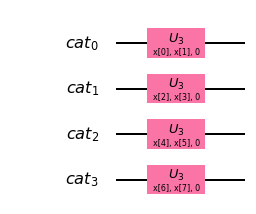

In [13]:
# Make feature map with encoder
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.algorithms import VQC
# from qiskit.aqua.compo
# feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')


X = [Parameter(f'x[{i}]') for i in range(data_train.shape[1])]

qr = QuantumRegister(num_qubit, 'cat')
qc = QuantumCircuit(qr)

for i in range(num_qubit):
    qc.u3(X[2*i], X[2*i+1], 0, i) # Encoder
# tmp1 = feature_map.assign_parameters(X[:num_qubit])
# tmp2 = feature_map.assign_parameters(X[num_qubit:])

feature_map_cat = qc #+ tmp1 + tmp2 
feature_map_cat.draw('mpl')

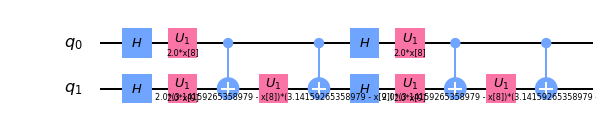

In [14]:
# Continuous circuit

X1 = Parameter('x[8]')
X2 = Parameter('x[9]')

feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')

feature_map = feature_map.assign_parameters([X1, X2])

feature_map.draw('mpl')

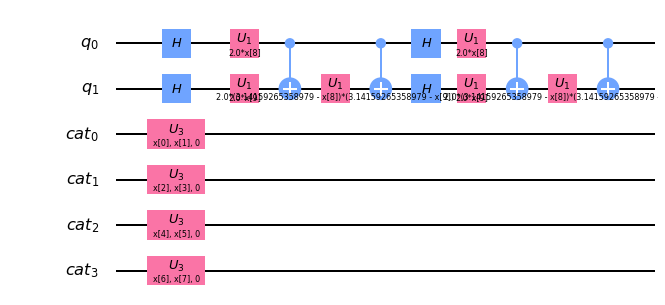

In [15]:
feature_map_all = feature_map.combine(feature_map_cat)
feature_map_all.draw('mpl')

In [16]:
# Make training data

training_input = {
    0: data_train[y_train == 0],
    1: data_train[y_train == 1]
}

In [17]:
# 

seed = 10598

vqc_encode_with_num_log = []
def loss_history_callback(_, __, loss, ___):
    vqc_encode_with_num_log.append(loss)


# feature_map = ZZFeatureMap(feature_dimension=num_qubit, reps=2, entanglement='linear')
var_form = variational_forms.RYRZ(6, depth=4)

qsvm_encode = VQC(SPSA(200), feature_map_all, var_form, training_input, callback=loss_history_callback)

# provider = IBMQ.get_provider(hub='ibm-q-utokyo')
# backend = provider.get_backend('ibmq_johannesburg')

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)


result = qsvm_encode.run(quantum_instance)

/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The qiskit.aqua.components.variational_forms.RYRZ object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.EfficientSU2 (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/barnrang/miniconda3/envs/liigo/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
            The <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> object as input for the VQC is deprecated as of 0.7.0 and will
            be removed no earlier than 3 months after the release.
            You should pass a QuantumCircuit object instead.
            See also qiskit.circuit.library.n_local for a collection
            of suitable circuits.
  del sys.path[0]
2020-07-10 01:40:17,159:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra

2020-07-10 01:59:44,875:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6978227864943641
2020-07-10 02:00:35,161:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6641369808805189
2020-07-10 02:01:29,489:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.7097806113555607
2020-07-10 02:02:21,961:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6479905685211301
2020-07-10 02:02:21,963:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 15 of 25
2020-07-10 02:03:00,663:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6597253254175388
2020-07-10 02:03:38,902:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6866470010219077
2020-07-10 02:04:18,250:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6640004356178763
2020-07-10 02:04:56,606:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6741018

2020-07-10 02:32:14,767:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.662704044552734
2020-07-10 02:32:53,947:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6858486679741306
2020-07-10 02:32:53,949:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: 0.6627040
2020-07-10 02:32:53,950:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 0.6858487
2020-07-10 02:33:41,818:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.690136191475854
2020-07-10 02:34:25,082:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6884959610126431
2020-07-10 02:34:25,084:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 0.6901362
2020-07-10 02:34:25,085:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 0.6884960
2020-07-10 02:35:07,824:qiskit.aqua.algorithms.cla

2020-07-10 02:57:18,114:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6037414599688735
2020-07-10 02:57:18,116:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 28: 0.6215160
2020-07-10 02:57:18,117:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 28: 0.6037415
2020-07-10 02:57:53,390:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.598652409977434
2020-07-10 02:58:29,317:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6203714847899428
2020-07-10 02:58:29,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 0.5986524
2020-07-10 02:58:29,320:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 0.6203715
2020-07-10 02:59:05,728:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.6071380334062831
2020-07-10 02:59:41,722:qiskit.aqua.algorithms.cl

2020-07-10 03:17:32,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 0.5861323
2020-07-10 03:17:32,313:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 0.5593678
2020-07-10 03:18:09,300:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5699069421854679
2020-07-10 03:18:45,429:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5683295455137718
2020-07-10 03:18:45,431:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 0.5699069
2020-07-10 03:18:45,432:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 0.5683295
2020-07-10 03:19:20,167:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5539767280377486
2020-07-10 03:19:57,785:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5732913575904321
2020-07-10 03:19:57,787:qiskit.aqua.components.o

2020-07-10 03:37:42,874:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 62: 0.5241803
2020-07-10 03:38:18,163:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5222037659720453
2020-07-10 03:38:53,464:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5412051569797188
2020-07-10 03:38:53,466:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 63: 0.5222038
2020-07-10 03:38:53,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 63: 0.5412052
2020-07-10 03:39:28,441:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5345577958532489
2020-07-10 03:40:04,229:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5155660243138442
2020-07-10 03:40:04,231:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 64: 0.5345578
2020-07-10 03:40:04,232:qiskit.aqua.components.o

2020-07-10 03:58:32,754:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5188152827385304
2020-07-10 03:59:07,878:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4939710980048807
2020-07-10 03:59:07,881:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 0.5188153
2020-07-10 03:59:07,882:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 80: 0.4939711
2020-07-10 03:59:43,402:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.5007676689997459
2020-07-10 04:00:19,085:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4986399900954613
2020-07-10 04:00:19,088:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 81: 0.5007677
2020-07-10 04:00:19,089:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 81: 0.4986400
2020-07-10 04:00:54,317:qiskit.aqua.algorithms.c

2020-07-10 04:19:10,918:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.49384996173594764
2020-07-10 04:19:10,921:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 97: 0.4860526
2020-07-10 04:19:10,922:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 97: 0.4938500
2020-07-10 04:19:47,119:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4881715133680305
2020-07-10 04:20:23,110:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4913710299543273
2020-07-10 04:20:23,113:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 98: 0.4881715
2020-07-10 04:20:23,113:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 98: 0.4913710
2020-07-10 04:20:59,060:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4884164469080427
2020-07-10 04:21:33,979:qiskit.aqua.algorithms.

2020-07-10 04:39:17,634:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 114: 0.4846210
2020-07-10 04:39:17,636:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 114: 0.4794160
2020-07-10 04:39:53,570:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4843528813282956
2020-07-10 04:40:28,755:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48606590530747434
2020-07-10 04:40:28,758:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 115: 0.4843529
2020-07-10 04:40:28,759:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 115: 0.4860659
2020-07-10 04:41:04,546:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48317436456200946
2020-07-10 04:41:39,695:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4823931471846053
2020-07-10 04:41:39,698:qiskit.aqua.compon

2020-07-10 04:59:30,414:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 131: 0.4840897
2020-07-10 05:00:07,003:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4832384816247759
2020-07-10 05:00:42,353:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4824674658420433
2020-07-10 05:00:42,356:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 132: 0.4832385
2020-07-10 05:00:42,357:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 132: 0.4824675
2020-07-10 05:01:17,747:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48361449069526463
2020-07-10 05:01:53,215:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4815972476986018
2020-07-10 05:01:53,218:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 133: 0.4836145
2020-07-10 05:01:53,219:qiskit.aqua.compone

2020-07-10 05:20:15,543:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4834343242923306
2020-07-10 05:20:50,897:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47948581849516664
2020-07-10 05:20:50,899:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 149: 0.4834343
2020-07-10 05:20:50,900:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 149: 0.4794858
2020-07-10 05:21:26,171:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48373640511076743
2020-07-10 05:22:01,136:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48375487245934473
2020-07-10 05:22:01,138:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 150: 0.4837364
2020-07-10 05:22:01,139:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 150: 0.4837549
2020-07-10 05:22:36,388:qiskit.aqua.algor

2020-07-10 05:42:57,508:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48048788561384537
2020-07-10 05:42:57,511:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 166: 0.4857042
2020-07-10 05:42:57,513:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 166: 0.4804879
2020-07-10 05:43:38,417:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4787465566052345
2020-07-10 05:44:20,696:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4781982284584361
2020-07-10 05:44:20,699:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 167: 0.4787466
2020-07-10 05:44:20,700:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 167: 0.4781982
2020-07-10 05:44:57,334:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.48441597922971863
2020-07-10 05:45:32,374:qiskit.aqua.algori

2020-07-10 06:03:22,448:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 183: 0.4757646
2020-07-10 06:03:22,449:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 183: 0.4791143
2020-07-10 06:03:58,733:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47574946472011714
2020-07-10 06:04:35,842:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47671805440113113
2020-07-10 06:04:35,845:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 184: 0.4757495
2020-07-10 06:04:35,847:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 184: 0.4767181
2020-07-10 06:05:11,701:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.4809099666584187
2020-07-10 06:05:46,915:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Intermediate batch cost: 0.47864556603867414
2020-07-10 06:05:46,917:qiskit.aqua.compo

In [18]:
def record_test_result_for_kaggle(y_pred, submission_file):
    start = 892
    end = 1309
    result = "PassengerId,Survived\n"
    for i in range(start, end + 1):
        result += "%d,%d\n" % (i, y_pred[i - 892])
    with open(submission_file, "w", encoding="utf-8") as writer:
        writer.write(result)

prediction = qsvm_encode.predict(data_test)[1]
record_test_result_for_kaggle(prediction, 'encode_with_num_submission.csv')

2020-07-10 06:23:04,491:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


In [79]:
# load model 
# qsvm_encode = VQC(COBYLA(1), feature_map, var_form, training_input)
# backend = BasicAer.get_backend('qasm_simulator')
# quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
# qsvm_encode.run(quantum_instance)

qsvm_encode.load_model('models/Titanic_VQC_withnum_SPSA.npz')

In [83]:
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
qsvm_encode.run(quantum_instance)

2020-07-10 01:30:30,638:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.14.1
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': 10598, 'optimization_level': None}
RunConfig(max_credits=10, seed_simulator=10598, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2020-07-10 01:30:30,641:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.14159

KeyboardInterrupt: 

In [21]:
prediction = qsvm_encode.predict(data_train)[1]

np.mean(prediction == y_train), f1_score(prediction, y_train)

2020-07-10 09:03:49,067:qiskit.aqua.algorithms.classifiers.vqc:DEBUG: Predicting batch 0


(0.7878787878787878, 0.7114503816793893)

Text(0, 0.5, 'loss')

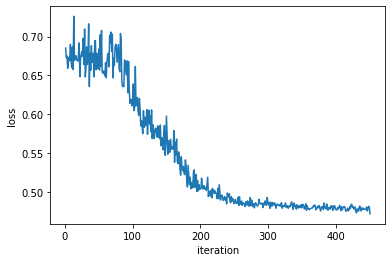

In [25]:
x_plot = np.arange(1,452)
plt.plot(x_plot, vqc_encode_with_num_log)
plt.xlabel('iteration')
plt.ylabel('loss')